# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

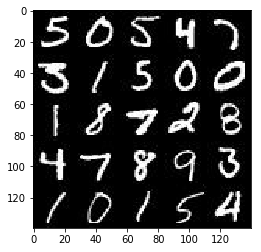

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot
import pickle as pkl

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

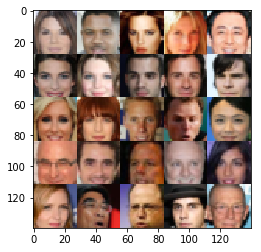

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate') 

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    train = True
    with tf.variable_scope('discriminator', reuse=reuse):
        x1= tf.layers.conv2d(images,64,4, strides=2, padding='same' )
        relu1 = tf.maximum(alpha*x1, x1)
        #14 x 14 x 64
        x2= tf.layers.conv2d(relu1, 128, 4, strides= 2, padding='same')
        x2= tf.layers.batch_normalization(x2, training=train)
        relu2 = tf.maximum(alpha*x2 , x2)
        #7 x 7 x 128
        x3= tf.layers.conv2d(relu2, 256, 4, strides= 2, padding='same')
        x3= tf.layers.batch_normalization(x3, training=train)
        relu3 = tf.maximum(alpha*x3 , x3)
        #4 x 4 x 256
        x4= tf.layers.conv2d(relu3, 512, 4, strides= 2, padding='same')
        x4= tf.layers.batch_normalization(x4, training=train)
        relu4 = tf.maximum(alpha*x4 , x4)
        #2 x 2 x 512
        flat= tf.reshape(relu4, (-1, 4*4*512))
        logits= tf.layers.dense(flat,1)
        out= tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 32x32x3 now
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-0.5, 0.5, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learningrate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
        
    samples, losses = [], []
    steps = 0

    print_every=10
    show_every=100
    
    out_channel_dim = 1 if data_image_mode == "L" else 3
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learningrate, beta1)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images*2
                # random noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real:batch_images, input_z:batch_z, lr:learningrate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real:batch_images, lr:learningrate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real:batch_images, lr:learningrate})
                

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real:batch_images})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 50, input_z, out_channel_dim, data_image_mode)

        #saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)

    return losses, samples
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.5349... Generator Loss: 0.1019
Epoch 1/2... Discriminator Loss: 3.1457... Generator Loss: 0.0562
Epoch 1/2... Discriminator Loss: 2.7929... Generator Loss: 0.1642
Epoch 1/2... Discriminator Loss: 2.1722... Generator Loss: 0.2009
Epoch 1/2... Discriminator Loss: 2.2474... Generator Loss: 0.1586
Epoch 1/2... Discriminator Loss: 2.4510... Generator Loss: 0.1082
Epoch 1/2... Discriminator Loss: 2.4435... Generator Loss: 0.0959
Epoch 1/2... Discriminator Loss: 2.1247... Generator Loss: 0.1403
Epoch 1/2... Discriminator Loss: 1.7774... Generator Loss: 0.2624
Epoch 1/2... Discriminator Loss: 1.9359... Generator Loss: 0.7899


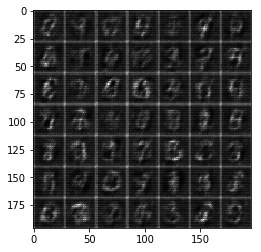

Epoch 1/2... Discriminator Loss: 1.4132... Generator Loss: 0.4344
Epoch 1/2... Discriminator Loss: 1.2242... Generator Loss: 0.7321
Epoch 1/2... Discriminator Loss: 2.3463... Generator Loss: 0.1163
Epoch 1/2... Discriminator Loss: 1.4650... Generator Loss: 0.4000
Epoch 1/2... Discriminator Loss: 1.1225... Generator Loss: 0.7473
Epoch 1/2... Discriminator Loss: 1.8771... Generator Loss: 0.2024
Epoch 1/2... Discriminator Loss: 1.2055... Generator Loss: 0.4627
Epoch 1/2... Discriminator Loss: 0.9730... Generator Loss: 0.9226
Epoch 1/2... Discriminator Loss: 1.5854... Generator Loss: 0.3008
Epoch 1/2... Discriminator Loss: 1.7596... Generator Loss: 0.2372


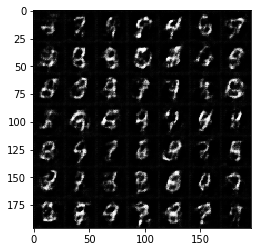

Epoch 1/2... Discriminator Loss: 1.8519... Generator Loss: 0.2357
Epoch 1/2... Discriminator Loss: 1.5603... Generator Loss: 0.3245
Epoch 1/2... Discriminator Loss: 1.5212... Generator Loss: 1.7008
Epoch 1/2... Discriminator Loss: 1.5785... Generator Loss: 0.3077
Epoch 1/2... Discriminator Loss: 1.2000... Generator Loss: 1.1079
Epoch 1/2... Discriminator Loss: 1.4961... Generator Loss: 0.3698
Epoch 1/2... Discriminator Loss: 1.9981... Generator Loss: 0.1877
Epoch 1/2... Discriminator Loss: 1.6357... Generator Loss: 0.3366
Epoch 1/2... Discriminator Loss: 1.2597... Generator Loss: 0.5150
Epoch 1/2... Discriminator Loss: 1.9549... Generator Loss: 0.1701


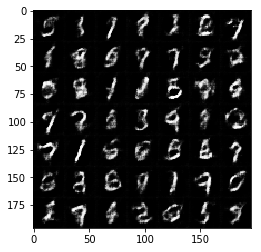

Epoch 1/2... Discriminator Loss: 1.6437... Generator Loss: 0.2647
Epoch 1/2... Discriminator Loss: 1.7043... Generator Loss: 0.2486
Epoch 1/2... Discriminator Loss: 2.8842... Generator Loss: 0.0718
Epoch 1/2... Discriminator Loss: 1.4738... Generator Loss: 0.3818
Epoch 1/2... Discriminator Loss: 1.5586... Generator Loss: 0.3200
Epoch 1/2... Discriminator Loss: 2.0178... Generator Loss: 0.1916
Epoch 1/2... Discriminator Loss: 2.1253... Generator Loss: 0.1386
Epoch 1/2... Discriminator Loss: 1.3183... Generator Loss: 0.4783
Epoch 1/2... Discriminator Loss: 1.3159... Generator Loss: 0.5584
Epoch 1/2... Discriminator Loss: 1.5963... Generator Loss: 0.3555


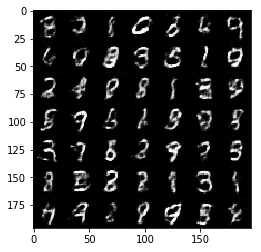

Epoch 1/2... Discriminator Loss: 1.6716... Generator Loss: 0.2888
Epoch 1/2... Discriminator Loss: 1.3399... Generator Loss: 1.9730
Epoch 1/2... Discriminator Loss: 1.4507... Generator Loss: 0.3845
Epoch 1/2... Discriminator Loss: 2.1313... Generator Loss: 0.1465
Epoch 1/2... Discriminator Loss: 2.2710... Generator Loss: 0.1396
Epoch 1/2... Discriminator Loss: 1.1191... Generator Loss: 0.8572
Epoch 2/2... Discriminator Loss: 2.2107... Generator Loss: 0.1455
Epoch 2/2... Discriminator Loss: 1.7603... Generator Loss: 0.2398
Epoch 2/2... Discriminator Loss: 0.9928... Generator Loss: 2.2854
Epoch 2/2... Discriminator Loss: 1.7910... Generator Loss: 0.2273


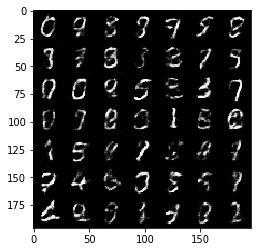

Epoch 2/2... Discriminator Loss: 1.5635... Generator Loss: 0.3029
Epoch 2/2... Discriminator Loss: 1.9971... Generator Loss: 0.1910
Epoch 2/2... Discriminator Loss: 1.3110... Generator Loss: 0.4475
Epoch 2/2... Discriminator Loss: 1.4427... Generator Loss: 0.3337
Epoch 2/2... Discriminator Loss: 1.6798... Generator Loss: 0.2688
Epoch 2/2... Discriminator Loss: 1.7454... Generator Loss: 0.2523
Epoch 2/2... Discriminator Loss: 1.8076... Generator Loss: 0.2314
Epoch 2/2... Discriminator Loss: 2.1754... Generator Loss: 0.1652
Epoch 2/2... Discriminator Loss: 2.0143... Generator Loss: 0.1792
Epoch 2/2... Discriminator Loss: 2.6143... Generator Loss: 0.0980


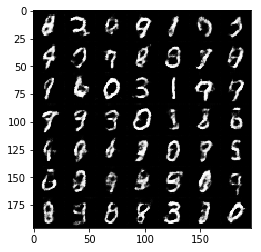

Epoch 2/2... Discriminator Loss: 1.1778... Generator Loss: 0.5410
Epoch 2/2... Discriminator Loss: 1.7930... Generator Loss: 0.2294
Epoch 2/2... Discriminator Loss: 1.7869... Generator Loss: 0.2793
Epoch 2/2... Discriminator Loss: 2.2046... Generator Loss: 0.1463
Epoch 2/2... Discriminator Loss: 1.8519... Generator Loss: 0.2607
Epoch 2/2... Discriminator Loss: 2.5347... Generator Loss: 0.1076
Epoch 2/2... Discriminator Loss: 1.8725... Generator Loss: 0.2240
Epoch 2/2... Discriminator Loss: 3.4459... Generator Loss: 0.0386
Epoch 2/2... Discriminator Loss: 0.9748... Generator Loss: 1.1428
Epoch 2/2... Discriminator Loss: 1.4988... Generator Loss: 0.3253


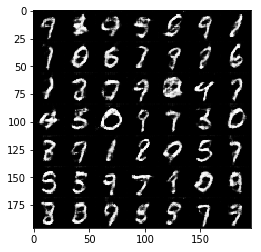

Epoch 2/2... Discriminator Loss: 1.4750... Generator Loss: 0.3507
Epoch 2/2... Discriminator Loss: 1.4364... Generator Loss: 0.4106
Epoch 2/2... Discriminator Loss: 1.5639... Generator Loss: 0.3063
Epoch 2/2... Discriminator Loss: 0.8581... Generator Loss: 1.0622
Epoch 2/2... Discriminator Loss: 1.3818... Generator Loss: 0.4680
Epoch 2/2... Discriminator Loss: 1.8774... Generator Loss: 0.2440
Epoch 2/2... Discriminator Loss: 1.9231... Generator Loss: 0.1938
Epoch 2/2... Discriminator Loss: 1.8042... Generator Loss: 0.2300
Epoch 2/2... Discriminator Loss: 1.8150... Generator Loss: 0.2161
Epoch 2/2... Discriminator Loss: 2.3060... Generator Loss: 0.1274


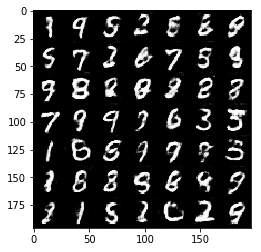

Epoch 2/2... Discriminator Loss: 2.0763... Generator Loss: 0.1915
Epoch 2/2... Discriminator Loss: 1.0062... Generator Loss: 0.7406
Epoch 2/2... Discriminator Loss: 4.7150... Generator Loss: 0.0162
Epoch 2/2... Discriminator Loss: 0.8568... Generator Loss: 0.9912
Epoch 2/2... Discriminator Loss: 1.1194... Generator Loss: 0.5701
Epoch 2/2... Discriminator Loss: 1.7924... Generator Loss: 0.2422
Epoch 2/2... Discriminator Loss: 1.4471... Generator Loss: 0.3567
Epoch 2/2... Discriminator Loss: 0.8957... Generator Loss: 0.7341
Epoch 2/2... Discriminator Loss: 2.4603... Generator Loss: 0.1117
Epoch 2/2... Discriminator Loss: 1.5095... Generator Loss: 0.3533


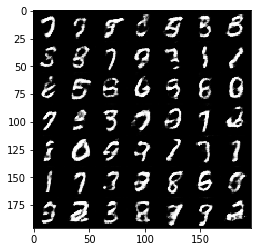

Epoch 2/2... Discriminator Loss: 1.1697... Generator Loss: 0.5626
Epoch 2/2... Discriminator Loss: 2.0643... Generator Loss: 0.1835
Epoch 2/2... Discriminator Loss: 1.7972... Generator Loss: 0.2698


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 5.7839... Generator Loss: 0.0041
Epoch 1/1... Discriminator Loss: 5.1187... Generator Loss: 0.0147
Epoch 1/1... Discriminator Loss: 3.6597... Generator Loss: 0.0277
Epoch 1/1... Discriminator Loss: 3.8935... Generator Loss: 0.0716
Epoch 1/1... Discriminator Loss: 3.3045... Generator Loss: 0.0457
Epoch 1/1... Discriminator Loss: 3.0709... Generator Loss: 0.0668
Epoch 1/1... Discriminator Loss: 2.5801... Generator Loss: 0.1165
Epoch 1/1... Discriminator Loss: 2.2099... Generator Loss: 0.3020
Epoch 1/1... Discriminator Loss: 2.4390... Generator Loss: 0.2710
Epoch 1/1... Discriminator Loss: 2.2172... Generator Loss: 0.2618


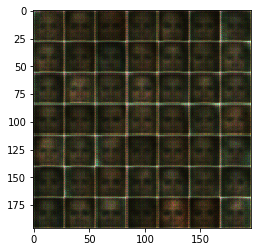

Epoch 1/1... Discriminator Loss: 1.7619... Generator Loss: 0.3924
Epoch 1/1... Discriminator Loss: 1.9194... Generator Loss: 0.2590
Epoch 1/1... Discriminator Loss: 1.9384... Generator Loss: 0.2440
Epoch 1/1... Discriminator Loss: 1.7695... Generator Loss: 0.4030
Epoch 1/1... Discriminator Loss: 1.8089... Generator Loss: 0.6303
Epoch 1/1... Discriminator Loss: 2.0071... Generator Loss: 0.2222
Epoch 1/1... Discriminator Loss: 1.8021... Generator Loss: 0.3298
Epoch 1/1... Discriminator Loss: 2.2617... Generator Loss: 0.1496
Epoch 1/1... Discriminator Loss: 1.8408... Generator Loss: 0.3194
Epoch 1/1... Discriminator Loss: 1.7173... Generator Loss: 0.3024


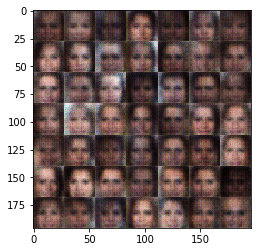

Epoch 1/1... Discriminator Loss: 1.6831... Generator Loss: 0.4536
Epoch 1/1... Discriminator Loss: 1.9282... Generator Loss: 0.2400
Epoch 1/1... Discriminator Loss: 2.0002... Generator Loss: 0.2469
Epoch 1/1... Discriminator Loss: 1.7753... Generator Loss: 0.4325
Epoch 1/1... Discriminator Loss: 1.6586... Generator Loss: 0.4052
Epoch 1/1... Discriminator Loss: 1.7949... Generator Loss: 0.4582
Epoch 1/1... Discriminator Loss: 1.6138... Generator Loss: 0.4979
Epoch 1/1... Discriminator Loss: 1.6571... Generator Loss: 0.4930
Epoch 1/1... Discriminator Loss: 1.6284... Generator Loss: 0.4595
Epoch 1/1... Discriminator Loss: 1.5831... Generator Loss: 0.5158


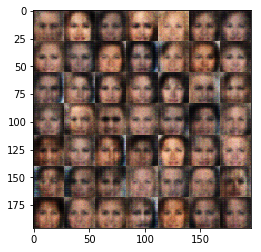

Epoch 1/1... Discriminator Loss: 1.5101... Generator Loss: 0.5029
Epoch 1/1... Discriminator Loss: 1.5716... Generator Loss: 0.4573
Epoch 1/1... Discriminator Loss: 1.7391... Generator Loss: 0.3795
Epoch 1/1... Discriminator Loss: 1.6169... Generator Loss: 0.4067
Epoch 1/1... Discriminator Loss: 1.5965... Generator Loss: 0.5235
Epoch 1/1... Discriminator Loss: 1.5258... Generator Loss: 0.3939
Epoch 1/1... Discriminator Loss: 1.4961... Generator Loss: 0.5205
Epoch 1/1... Discriminator Loss: 1.5977... Generator Loss: 0.4221
Epoch 1/1... Discriminator Loss: 1.6050... Generator Loss: 0.3849
Epoch 1/1... Discriminator Loss: 1.6357... Generator Loss: 0.3925


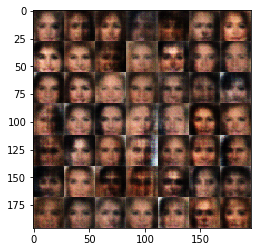

Epoch 1/1... Discriminator Loss: 1.5949... Generator Loss: 0.4853
Epoch 1/1... Discriminator Loss: 1.6335... Generator Loss: 0.4248
Epoch 1/1... Discriminator Loss: 1.5160... Generator Loss: 0.5727
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.5514
Epoch 1/1... Discriminator Loss: 1.5224... Generator Loss: 0.4235
Epoch 1/1... Discriminator Loss: 1.6053... Generator Loss: 0.3981
Epoch 1/1... Discriminator Loss: 1.5264... Generator Loss: 0.4432
Epoch 1/1... Discriminator Loss: 1.6006... Generator Loss: 0.5423
Epoch 1/1... Discriminator Loss: 1.4868... Generator Loss: 0.4568
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.6924


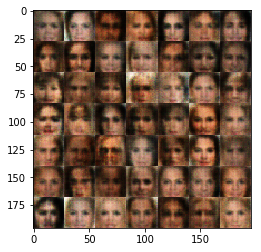

Epoch 1/1... Discriminator Loss: 1.5553... Generator Loss: 0.5380
Epoch 1/1... Discriminator Loss: 1.5362... Generator Loss: 0.4588
Epoch 1/1... Discriminator Loss: 1.4985... Generator Loss: 0.4480
Epoch 1/1... Discriminator Loss: 1.5505... Generator Loss: 0.4816
Epoch 1/1... Discriminator Loss: 1.5869... Generator Loss: 0.9208
Epoch 1/1... Discriminator Loss: 1.6449... Generator Loss: 0.4352
Epoch 1/1... Discriminator Loss: 1.5195... Generator Loss: 0.4258
Epoch 1/1... Discriminator Loss: 1.4756... Generator Loss: 0.5894
Epoch 1/1... Discriminator Loss: 1.6363... Generator Loss: 0.3780
Epoch 1/1... Discriminator Loss: 1.5801... Generator Loss: 0.3955


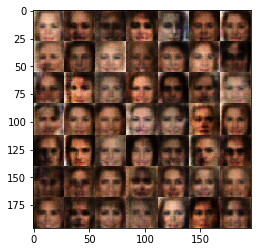

Epoch 1/1... Discriminator Loss: 1.5610... Generator Loss: 0.5964
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.4638
Epoch 1/1... Discriminator Loss: 1.4648... Generator Loss: 0.5716
Epoch 1/1... Discriminator Loss: 1.5377... Generator Loss: 0.5243
Epoch 1/1... Discriminator Loss: 1.5729... Generator Loss: 0.5539
Epoch 1/1... Discriminator Loss: 1.5834... Generator Loss: 0.3786
Epoch 1/1... Discriminator Loss: 1.4813... Generator Loss: 0.5053
Epoch 1/1... Discriminator Loss: 1.6681... Generator Loss: 0.3003
Epoch 1/1... Discriminator Loss: 1.4715... Generator Loss: 0.5321
Epoch 1/1... Discriminator Loss: 1.5430... Generator Loss: 0.4504


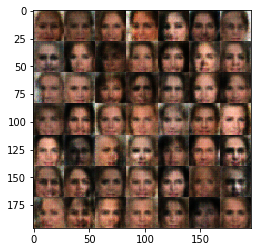

Epoch 1/1... Discriminator Loss: 1.8127... Generator Loss: 0.2340
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.5445
Epoch 1/1... Discriminator Loss: 1.7088... Generator Loss: 0.2594
Epoch 1/1... Discriminator Loss: 1.7634... Generator Loss: 0.2347
Epoch 1/1... Discriminator Loss: 1.6140... Generator Loss: 0.3942
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.7705... Generator Loss: 0.2514
Epoch 1/1... Discriminator Loss: 1.6758... Generator Loss: 0.5673
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.5299
Epoch 1/1... Discriminator Loss: 1.6271... Generator Loss: 0.5033


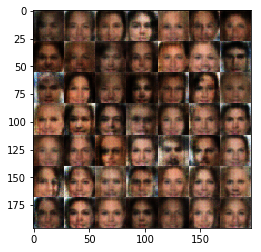

Epoch 1/1... Discriminator Loss: 1.5010... Generator Loss: 0.4565
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.6106
Epoch 1/1... Discriminator Loss: 1.9135... Generator Loss: 0.2137
Epoch 1/1... Discriminator Loss: 1.6660... Generator Loss: 0.3366
Epoch 1/1... Discriminator Loss: 1.7436... Generator Loss: 0.3433
Epoch 1/1... Discriminator Loss: 1.6457... Generator Loss: 0.3729
Epoch 1/1... Discriminator Loss: 1.5363... Generator Loss: 0.5312
Epoch 1/1... Discriminator Loss: 1.5855... Generator Loss: 0.8828
Epoch 1/1... Discriminator Loss: 1.8930... Generator Loss: 0.2607
Epoch 1/1... Discriminator Loss: 1.6864... Generator Loss: 0.4637


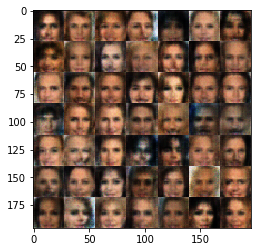

Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.5529
Epoch 1/1... Discriminator Loss: 1.5739... Generator Loss: 0.8616
Epoch 1/1... Discriminator Loss: 1.5868... Generator Loss: 0.4337
Epoch 1/1... Discriminator Loss: 1.9997... Generator Loss: 0.2491
Epoch 1/1... Discriminator Loss: 1.4878... Generator Loss: 0.4288
Epoch 1/1... Discriminator Loss: 1.5292... Generator Loss: 0.4640
Epoch 1/1... Discriminator Loss: 1.7452... Generator Loss: 0.3827
Epoch 1/1... Discriminator Loss: 1.7063... Generator Loss: 0.3171
Epoch 1/1... Discriminator Loss: 1.6043... Generator Loss: 0.3879
Epoch 1/1... Discriminator Loss: 1.7799... Generator Loss: 0.2814


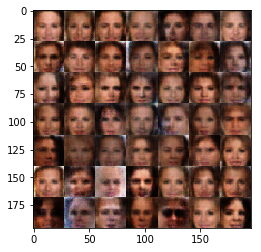

Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.8364
Epoch 1/1... Discriminator Loss: 1.6327... Generator Loss: 0.3363
Epoch 1/1... Discriminator Loss: 1.7065... Generator Loss: 0.3005
Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.5545
Epoch 1/1... Discriminator Loss: 1.6094... Generator Loss: 0.5816
Epoch 1/1... Discriminator Loss: 1.6096... Generator Loss: 0.3273
Epoch 1/1... Discriminator Loss: 1.1395... Generator Loss: 1.4209
Epoch 1/1... Discriminator Loss: 1.4750... Generator Loss: 0.9780
Epoch 1/1... Discriminator Loss: 1.5934... Generator Loss: 0.3488
Epoch 1/1... Discriminator Loss: 1.5521... Generator Loss: 0.4222


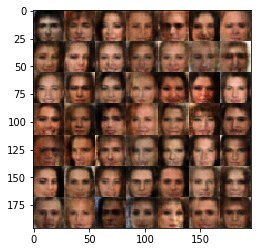

Epoch 1/1... Discriminator Loss: 1.8441... Generator Loss: 0.2600
Epoch 1/1... Discriminator Loss: 1.9260... Generator Loss: 0.2550
Epoch 1/1... Discriminator Loss: 1.9785... Generator Loss: 0.1890
Epoch 1/1... Discriminator Loss: 1.7201... Generator Loss: 0.4493
Epoch 1/1... Discriminator Loss: 1.6714... Generator Loss: 0.8874
Epoch 1/1... Discriminator Loss: 1.5766... Generator Loss: 0.3932
Epoch 1/1... Discriminator Loss: 1.6635... Generator Loss: 0.2775
Epoch 1/1... Discriminator Loss: 1.6069... Generator Loss: 0.4286
Epoch 1/1... Discriminator Loss: 1.9283... Generator Loss: 0.2009
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.5496


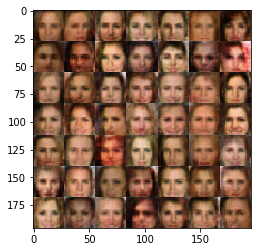

Epoch 1/1... Discriminator Loss: 1.6051... Generator Loss: 0.3641
Epoch 1/1... Discriminator Loss: 1.4795... Generator Loss: 0.3888
Epoch 1/1... Discriminator Loss: 1.5862... Generator Loss: 0.5511
Epoch 1/1... Discriminator Loss: 1.9446... Generator Loss: 0.2404
Epoch 1/1... Discriminator Loss: 1.2250... Generator Loss: 1.1855
Epoch 1/1... Discriminator Loss: 1.5762... Generator Loss: 0.4110
Epoch 1/1... Discriminator Loss: 1.6676... Generator Loss: 0.3146
Epoch 1/1... Discriminator Loss: 1.8565... Generator Loss: 0.2267
Epoch 1/1... Discriminator Loss: 1.5765... Generator Loss: 0.3978
Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 0.7741


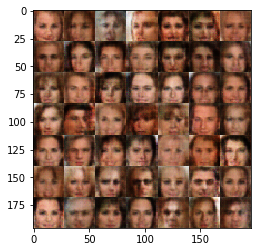

Epoch 1/1... Discriminator Loss: 1.7335... Generator Loss: 0.2774
Epoch 1/1... Discriminator Loss: 1.5781... Generator Loss: 0.3432
Epoch 1/1... Discriminator Loss: 1.8847... Generator Loss: 0.2857
Epoch 1/1... Discriminator Loss: 1.5483... Generator Loss: 0.5247
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.4670
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 1.0192
Epoch 1/1... Discriminator Loss: 1.9167... Generator Loss: 0.1955
Epoch 1/1... Discriminator Loss: 1.8852... Generator Loss: 0.2182
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.6357


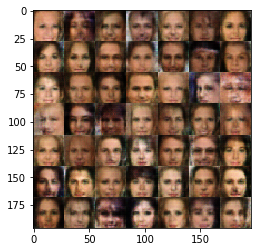

Epoch 1/1... Discriminator Loss: 1.4983... Generator Loss: 0.4161
Epoch 1/1... Discriminator Loss: 1.6774... Generator Loss: 0.4264
Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 0.9953
Epoch 1/1... Discriminator Loss: 1.7407... Generator Loss: 0.3169
Epoch 1/1... Discriminator Loss: 1.5834... Generator Loss: 0.4218
Epoch 1/1... Discriminator Loss: 1.8303... Generator Loss: 0.4071
Epoch 1/1... Discriminator Loss: 1.6183... Generator Loss: 0.4503
Epoch 1/1... Discriminator Loss: 1.5348... Generator Loss: 0.6186
Epoch 1/1... Discriminator Loss: 1.1493... Generator Loss: 1.0866
Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 1.2385


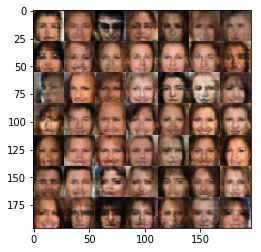

Epoch 1/1... Discriminator Loss: 1.6432... Generator Loss: 0.3455
Epoch 1/1... Discriminator Loss: 1.9190... Generator Loss: 0.1970
Epoch 1/1... Discriminator Loss: 0.8380... Generator Loss: 1.6833
Epoch 1/1... Discriminator Loss: 1.6947... Generator Loss: 0.3717
Epoch 1/1... Discriminator Loss: 1.9882... Generator Loss: 0.1816
Epoch 1/1... Discriminator Loss: 1.5002... Generator Loss: 0.3789
Epoch 1/1... Discriminator Loss: 1.5112... Generator Loss: 0.8525
Epoch 1/1... Discriminator Loss: 2.1218... Generator Loss: 0.1589


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.